### Imports

In [1]:
import pandas as pd 
import seaborn as sns 
import random
import math

### Generate test data

In [2]:
#This function generates test data for stars with ra, dec and magnitude for "plate" data and "gaia" data

#random.seed(1)
n = 1000 #number of stars
i = 0
dt = [] #ideal
dt1 = [] #plate(apt)
dt2 = [] #"truth" (gaia)
er = 0.1 #deviation from "ideal" data

#for same number of stars
while i < n:
    dt.append([round(random.uniform(1,10), 2),round(random.uniform(1,10), 2),round(random.uniform(5,15), 2)])
    dt1.append([(dt[i][0]-round(random.uniform(-er,er), 2)), (dt[i][1]-round(random.uniform(-er,er), 2)), \
                (dt[i][2]-round(random.uniform(-er,er), 2))])
    dt2.append([(dt[i][0]-round(random.uniform(-er,er), 2)), (dt[i][1]-round(random.uniform(-er,er), 2)), \
                (dt[i][2]-round(random.uniform(-er,er), 2))])
    i+=1

df_apt = pd.DataFrame(dt1, columns = ['CentroidRA', 'CentroidDec', 'Magnitude'])
df_gaia = pd.DataFrame(dt2, columns = ['ra', 'dec','phot_bp_mean_mag']) 

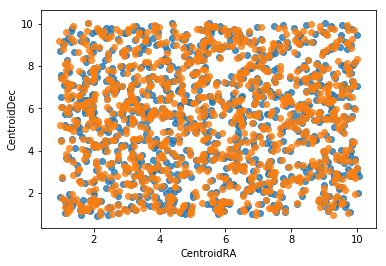

In [3]:
sns.regplot('ra','dec',data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec',data=df_apt, fit_reg = False)

### Combined data
- Combine data based on similarities between ra&dec
- Create new combined data
- Delete overlapping terms

In [4]:
m = 0
maxdiff = 0.5
df_gaia = df_gaia.sort_values('ra').reset_index(drop=True)
df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','CentroidRA','CentroidDec','Magnitude','diff'])

while m < 1000:#apt
    n = 0
    df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
    while n<1000:#gaia
        if df_apt['CentroidRA'][m] - maxdiff > df_gaia['ra'][n]: 
            n+=1
        elif df_apt['CentroidRA'][m] - maxdiff <= df_gaia['ra'][n] <= df_apt['CentroidRA'][m] + maxdiff :
            if df_apt['CentroidDec'][m] - maxdiff <= df_gaia['dec'][n] <= df_apt['CentroidDec'][m] + maxdiff :
                df_temp = df_temp.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n], \
                                          'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                                          'diff':  math.sqrt((df_gaia['ra'][n]-df_apt['CentroidRA'][m])**2+\
                                                             (df_gaia['dec'][n]-df_apt['CentroidDec'][m])**2)},\
                                         ignore_index=True)
            n+=1
        else :
            break
    df_temp = df_temp.nsmallest(1, 'diff').reset_index(drop=True)
    df = df.append({'ra': df_temp['ra'][0], \
                    'dec': df_temp['dec'][0],\
                    'phot_bp_mean_mag': df_temp['phot_bp_mean_mag'][0],\
                    'CentroidRA': df_apt['CentroidRA'][m],\
                    'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': df_temp['diff'][0]}, ignore_index=True)
    m+=1

#df_temp
df

#filter repetitions 
#filter diff > maxdiff

,ra,dec,phot_bp_mean_mag,CentroidRA,CentroidDec,Magnitude,diff
0,4.79,5.18,10.91,4.62,5.12,7.32,0.180278
1,2.29,9.49,8.46,2.22,9.49,8.58,0.070000
2,2.48,9.54,13.70,2.53,9.40,13.61,0.148661
3,2.59,7.19,8.02,2.54,7.13,10.19,0.078102
4,4.16,8.95,11.24,4.21,9.14,11.22,0.196469
5,2.61,5.40,11.54,2.60,5.27,11.49,0.130384
6,9.69,7.86,10.82,9.75,7.86,5.79,0.060000
7,4.57,2.20,7.15,4.47,2.27,7.15,0.122066
8,2.94,1.24,10.62,2.91,1.23,10.56,0.031623
9,5.40,5.66,5.46,5.34,5.70,5.45,0.072111


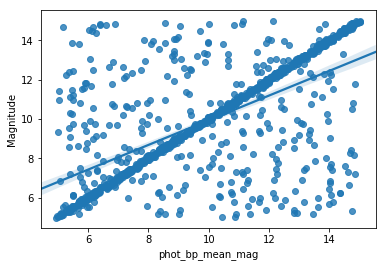

In [5]:
sns.regplot('phot_bp_mean_mag','Magnitude',data=df)

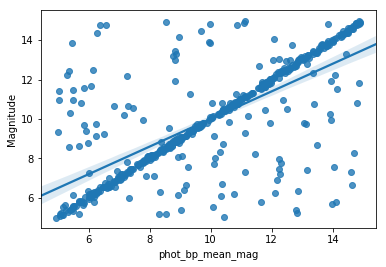

In [6]:
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df)

In [7]:
df

,ra,dec,phot_bp_mean_mag,CentroidRA,CentroidDec,Magnitude,diff
202,2.86,7.03,8.89,2.86,7.03,8.82,0.000000
469,1.81,10.02,11.56,1.81,10.02,11.58,0.000000
572,3.34,4.56,11.14,3.34,4.56,11.09,0.000000
697,6.33,4.16,12.50,6.33,4.15,10.49,0.010000
524,5.93,1.61,12.17,5.94,1.61,6.89,0.010000
102,8.52,8.28,8.66,8.52,8.27,8.71,0.010000
594,9.03,3.67,6.24,9.03,3.66,6.16,0.010000
614,5.45,8.59,5.50,5.46,8.59,5.51,0.010000
253,8.99,3.97,9.39,8.98,3.97,9.43,0.010000
229,7.30,7.75,12.40,7.30,7.76,12.44,0.010000
